# Anomaly detection in time-series : forecasting
This notebook demonstrates anomaly detection in time series using forecasting methods. Anomaly detection by forecasting involves training models to forecast future values of a time series and identifying anomalies based on deviations between the predicted and actual values. The techniques covered include:

- Statistical methods
- Deep learning models

## Necessary imports

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Custom modules
from data_preprocessing import DataPreprocessor, SimpleDataSet, DataLoaderNAB

torch.set_default_dtype(torch.float32)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data
To compare each model, we will use real-life data from the [NAB dataset][nab].

[nab]: https://github.com/numenta/NAB

The specific data used in this notebook is from the `realAdExchange/exchange-3_cpc_results` file. This dataset contains timestamped values representing the cost-per-click (CPC) results over a period of time. The dataset includes:

- `timestamp`: The date and time of the recorded value.
- `value`: The CPC value recorded at the corresponding timestamp.

We will use this data to train and evaluate our anomaly detection models.


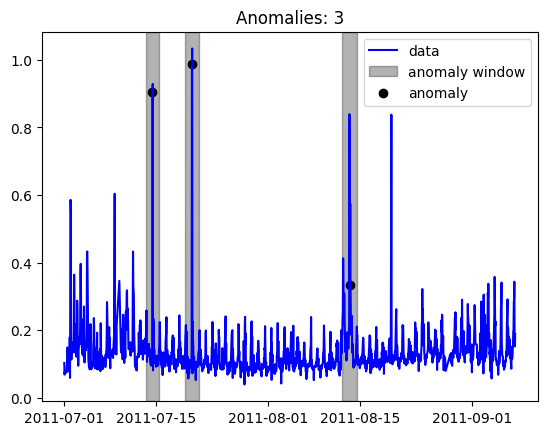

In [3]:
# Use convenience functions to load and visualize the time series
df, anomaly_times, anomaly_windows = DataLoaderNAB.load_data('data.csv', 'anomaly_times.json', 'windows.json')

U = [] # we don't have any external features
Y = df["value"].values

fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax);

## Methods

### Statistical Methods

In this section, we explore various statistical methods used for anomaly detection. These methods leverage statistical properties of the data to identify outliers or anomalies. Common techniques include:

1. **Moving Average**: Smooths data by averaging over a sliding window. Anomalies are identified when data points deviate significantly from the moving average.

2. **Exponential Smoothing**: Similar to moving average but gives more weight to recent observations. Anomalies are detected based on deviations from the smoothed values.

3. **ARIMA (AutoRegressive Integrated Moving Average)**: A popular statistical method for time series forecasting. It combines autoregression, differencing, and moving average components to model the data. Anomalies are detected based on the residuals (prediction errors) from the ARIMA model.


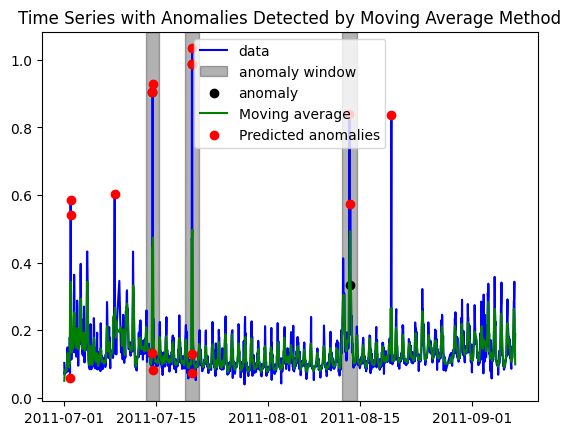

In [4]:
def apply_moving_average(Y, window_size=5):
    """Apply moving average to a time series and return the same size as Y."""
    moving_avg = np.convolve(Y, np.ones(window_size)/window_size, mode='same')
    return moving_avg

# Apply moving average
moving_avg_values = apply_moving_average(Y)
pred_error_moving_avg = Y - moving_avg_values

# Anomaly detection based on prediction error
pred_error_threshold_ma = 3.5 * np.std(moving_avg_values)
predicted_anomalies_moving_avg = np.where(np.abs(pred_error_moving_avg) > pred_error_threshold_ma)[0]


# Plot
fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax)
ax.plot(df["timestamp"], moving_avg_values, label='Moving average', color='green')
ax.scatter(df["timestamp"][predicted_anomalies_moving_avg], Y[predicted_anomalies_moving_avg], color='red', label='Predicted anomalies', zorder=5)
ax.set_title('Time Series with Anomalies Detected by Moving Average Method')
ax.legend(loc='best')



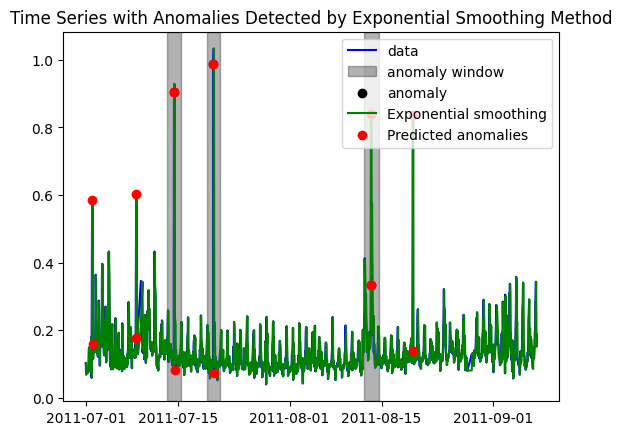

In [5]:
def apply_exponential_smoothing(Y, smoothing_level=0.2):
    """Apply exponential smoothing to a time series."""

    model = ExponentialSmoothing(Y, trend=None, seasonal=None)
    model_fit = model.fit(smoothing_level=smoothing_level)
    return model_fit.fittedvalues


# Apply exponential smoothing
exp_smoothing_values = apply_exponential_smoothing(Y, smoothing_level=0.98)
pred_error_exp_smoothing = Y - exp_smoothing_values


# Anomaly detection based on prediction error
pred_error_threshold = 3.5 * np.std(exp_smoothing_values)
predicted_anomalies_exp_smoothing = np.where(np.abs(pred_error_exp_smoothing) > pred_error_threshold)[0]

# Plot
fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax)
ax.plot(df["timestamp"], exp_smoothing_values, label='Exponential smoothing', color='green')

ax.scatter(df["timestamp"][predicted_anomalies_exp_smoothing], Y[predicted_anomalies_exp_smoothing], color='red', label='Predicted anomalies', zorder=5)
ax.set_title('Time Series with Anomalies Detected by Exponential Smoothing Method')
ax.legend(loc='best')
plt.show()



Using specified ARIMA order: (4, 1, 1)


c:\AlpRepos\time_series_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\AlpRepos\time_series_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


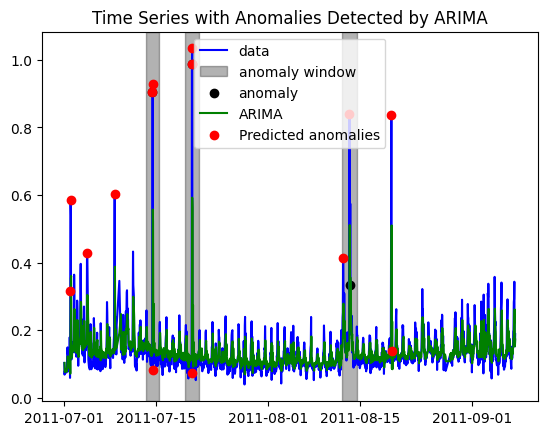

In [6]:
def fit_arima_model(Y, specified_order=None):
    """
    Create and fit and ARIMA model to the given time series data.

    If order is not specified, auto_arima is used to find the best order.
    """
    if specified_order:
        print(f"Using specified ARIMA order: {specified_order}")
        model = ARIMA(Y, order=specified_order)
    else:
        print("Using auto_arima to select the best ARIMA model...")
        auto_model = auto_arima(Y, seasonal=False, suppress_warnings=True, stepwise=True)
        print(f"Best ARIMA order found: {auto_model.order}")
        model = ARIMA(Y, order=auto_model.order)

    model_fit = model.fit()
    return model_fit

# Example usage:
specified_order = (4, 1, 1)  # Example: (5, 1, 0) or None for auto_arima

# Fit the ARIMA model
model_fit = fit_arima_model(Y, specified_order)

# Predict values
predictions = model_fit.predict(start=1, end=len(Y)-1)

# Calculate residuals (prediction errors)
pred_error_arima = Y[1:] - predictions

# Anomaly detection based on 3 standard deviations
threshold = 3.5 * np.std(pred_error_arima)
anomalies = np.where(np.abs(pred_error_arima) > threshold)[0] + 1  # Offset by 1 due to prediction shift

# Plot actual data, predictions, and anomalies
fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax)

ax.plot(df["timestamp"][1:], predictions, label='ARIMA', color='green')
ax.scatter(df["timestamp"][anomalies], Y[anomalies], color='red', label='Predicted anomalies', zorder=5)
ax.set_title('Time Series with Anomalies Detected by ARIMA')
ax.legend(loc='best')
plt.show()


### Deep learning methods
In this section, we will explore the use of machine learning models for anomaly detection in time series data. Specifically, we will use a Multi-Layer Perceptron (MLP) and a Long Short-Term Memory (LSTM) network.

- *Multi-Layer Perceptron (MLP)*: The MLP model is a type of feedforward artificial neural network. It consists of multiple layers of nodes, each fully connected to the next layer. MLPs are suitable for tasks where the input data is structured and the relationships between the features are complex.

- *Long Short-Term Memory (LSTM)*: The LSTM model is a type of recurrent neural network (RNN) that is well-suited for sequence prediction problems. LSTMs are capable of learning long-term dependencies in the data.

Both the MLP and LSTM models are trained using the NARX framework. NARX is a type of model that is used for modeling time series data. It uses past values of the target variable (autoregressive terms) and values of external inputs (exogenous terms) to predict future values. This makes NARX particularly effective for capturing the dynamics of time series data with external influences.

The NARX model can be represented by the following equation:

$$
y(t) = f(y(t-1), y(t-2), \ldots, y(t-n), u(t), u(t-1), \ldots, u(t-m))
$$

where $y(t) is the target variable and $u(t)$ is the exogenous variable.

We will train both models on our dataset and compare their performance in terms of prediction accuracy and anomaly detection.


In [7]:
class Network(nn.Module):
    """MLP with series of Forward-BatchNorm-Activation layers."""

    def __init__(self, n_nodes_list=[1, 32, 1], activation_fn=torch.relu):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(node_in, node_out)
                for node_in, node_out in zip(n_nodes_list[:-2], n_nodes_list[1:-1])
            ]
        )
        self.batchnorm_layers = nn.ModuleList(
            [nn.BatchNorm1d(node_in) for node_in in n_nodes_list[1:-1]]
        )
        self.lastlayer = nn.Linear(n_nodes_list[-2], n_nodes_list[-1])
        self.activation_fn = activation_fn

    def forward(self, x):
        for layer_idx, (layer, bn) in enumerate(
            zip(self.layers, self.batchnorm_layers)
        ):
            x = self.activation_fn(bn(layer(x)))
        y = self.lastlayer(x)
        return y


class LSTMWithEncoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, history_size=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # short hand for a 1 hidden layer NN
        net = lambda n_in, n_out: Network([n_in, 40, n_out])
        self.encoder = net(history_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=self.input_size, hidden_size=hidden_size, batch_first=True
        )
        self.h2o = net(hidden_size + self.input_size, self.output_size)  # i)

    def forward(self, inputs, hist):
        # inputs: [n_batch, n_sequence] (assumed 1 feature)
        # hist: [n_batch, n_history]
        h_0 = self.encoder(hist)[None, :, :]  # [1, n_batch, self.hidden_size]
        c_0 = torch.zeros(h_0.shape)  # [1, n_batch, self.hidden_size]

        # 1 layer LSTM with batch_first = True expects
        # INPUTS
        # input --> (n_batch, n_sequence, n_features)
        # h_0 --> (n_layer=1,n_batch, n_hidden)
        # c_0 --> (n_layer=1,n_batch, n_hidden)
        # OUTPUTS
        # hiddens: [n_batch, n_sequence, self.hidden_size]
        # Each hidden state is a vector of size self.hidden_size, representing the learned representation at each time step (n_sequence).
        # h_n: [self.output_size, n_features, self.hidden_size]
        # combined creates a feature vector which is the combination of the input + learned representation output from LSTM
        if inputs.ndim == 2:
            hiddens, (h_n, c_n) = self.lstm(inputs[:, :, None], (h_0, c_0))
            combined = torch.cat(
                (hiddens, inputs[:, :, None]), dim=2
            )  # [n_batch, n_sequence, n_hidden + n_features]
        else:
            hiddens, (h_n, c_n) = self.lstm(inputs, (h_0, c_0))
            combined = torch.cat(
                (hiddens), dim=2
            )  # [n_batch, n_sequence, n_hidden + n_features]

        # Since self.h2o predicts on the elements in last dimension, we can loop here by using `view`
        # For example, view [5,10,8] as [50,8] to get an output of shape [50, self.output_size], then reshape it back to [5, 10, self.output_size]
        h2o_input = combined.view(
            -1, self.hidden_size + self.input_size
        )  # [n_batch * n_sequence, n_hidden + n_features]
        y_predict = self.h2o(h2o_input).view(
            inputs.shape[0], inputs.shape[1]
        )  # [n_batch, n_sequence]
        return y_predict[:, -1][
            :, None
        ]  # Use the last output from the sequence as the output


In [8]:
# Configurations of the models and the training scheme
n_ar = 5 # number of auto-regressive terms to include into NARX model
n_hist = 3 # number of historical samples to consider (this is used to initialize the first hidden state of the LSTM)
test_size = 0.3 # percentage of the dataset to use as test set
batch_size = 0.5 # percentage of the training dataset to use as batch size
mlp_activation_fn = torch.relu # activation function for the MLP

In [9]:
to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

def create_NARX_dataset(U, Y, n_ar=0, n_hist=0, n_b=0, n_hist_u=0, test_size=0.1):
    to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

    Xdata, Ydata, Hdata = DataPreprocessor.create_NARX_model(U, Y, n_ar=n_ar, n_b=n_b, return_history=True, n_hist_y=n_hist, n_hist_u=n_hist_u, output_as_tuple=False)
    Xdata, Ydata, Hdata = to_tensor([Xdata, Ydata, Hdata])
    Xtrain, Xval, Ytrain, Yval, Htrain, Hval = train_test_split(Xdata, Ydata, Hdata, test_size=test_size, shuffle=True)

    return Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata

def create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=10):
    n_samples = len(Ytrain)
    n_batch = round(batch_size * n_samples)
    assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"

    train_dl_net = DataLoader(SimpleDataSet(Xtrain, Ytrain), batch_size=n_batch, shuffle=True)
    train_dl_lstm = DataLoader(SimpleDataSet((Xtrain, Htrain), Ytrain), batch_size=n_batch, shuffle=True)
    val_dl_net = DataLoader(SimpleDataSet(Xval, Yval), batch_size=n_batch, shuffle=True)
    val_dl_lstm = DataLoader(SimpleDataSet((Xval, Hval), Yval), batch_size=n_batch, shuffle=True)

    return train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm

Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata = create_NARX_dataset(U, Y, n_ar, n_hist, n_b=0, n_hist_u=0, test_size=test_size)
train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm = create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=batch_size)


n_burn_in = df['value'].shape[0] - Xdata.shape[0] # number of burn-in samples

print(Xdata.shape, Ydata.shape, Hdata.shape)

torch.Size([1529, 5]) torch.Size([1529, 1]) torch.Size([1529, 3])


In [10]:
# Create convenience functions for training and testing the model

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model_lstm to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if isinstance(X, torch.Tensor):
            pred = model(X)
        else:
            pred = model(*X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            if isinstance(X, torch.Tensor):
                pred = model(X)
            else:
                pred = model(*X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def fit_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs = 1, log_interval = None):
    loss_train = []
    loss_val = []
    if not log_interval:
        log_interval = round(epochs * 0.1)
    for t in range(epochs):
        loss_t = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_v = test_loop(test_dataloader, model, loss_fn)
        loss_train.append(loss_t)
        loss_val.append(loss_v)

        if t % log_interval == 0:
            print(f"Epoch {t+1}, Train loss = {loss_t}, Test loss = {loss_v} \n-------------------------------")
    return loss_train, loss_val

In [11]:
# Create models
n_output = 1 if Ytrain.ndim == 1 else Ytrain.shape[-1]
model_net = Network([n_ar, 32, n_output], activation_fn=mlp_activation_fn)
model_lstm = LSTMWithEncoder(
    input_size=1,  # number of features in a time step --> input is univariate
    hidden_size=max(n_hist * 5, 40),
    output_size=n_output,
    history_size=n_hist,
)

In [12]:
# Train models and check validation loss
loss_fn = nn.MSELoss()
optimizer_net = torch.optim.Adam(model_net.parameters())
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
epochs = 101
loss_train = []
loss_val = []

loss_train_lstm, loss_val_lstm = fit_loop(train_dl_lstm, val_dl_lstm, model_lstm, loss_fn, optimizer_lstm, epochs)
loss_train_net, loss_val_net = fit_loop(train_dl_net, val_dl_net, model_net, loss_fn, optimizer_net, epochs)

Epoch 1, Train loss = 0.013971954584121704, Test loss = 0.07512708753347397 
-------------------------------
Epoch 11, Train loss = 0.0056863329373300076, Test loss = 0.07439707964658737 
-------------------------------
Epoch 21, Train loss = 0.004314007703214884, Test loss = 0.05077444016933441 
-------------------------------
Epoch 31, Train loss = 0.0025856136344373226, Test loss = 0.015574340708553791 
-------------------------------
Epoch 41, Train loss = 0.004261343274265528, Test loss = 0.005160373169928789 
-------------------------------
Epoch 51, Train loss = 0.004001997876912355, Test loss = 0.004496958572417498 
-------------------------------
Epoch 61, Train loss = 0.0020468318834900856, Test loss = 0.004541554022580385 
-------------------------------
Epoch 71, Train loss = 0.003221415216103196, Test loss = 0.005149487406015396 
-------------------------------
Epoch 81, Train loss = 0.0022072645369917154, Test loss = 0.0044327471405267715 
-------------------------------


In [13]:
# Get prediction error from themodels
model_net.eval()
with torch.no_grad():
    y_pred_net = model_net(Xdata)
    y_pred_lstm = model_lstm(Xdata, Hdata)

pred_error_lstm = np.squeeze(Ydata - y_pred_lstm).numpy()
pred_error_net = np.squeeze(Ydata - y_pred_net).numpy()

In [14]:
def plot_results_training(axs, y_pred, loss_train, loss_val, model_name, color):
    # plot predicted result
    axs[0].plot(y_pred, label=f'Predicted time series - {model_name}', color=color)
    axs[0].set_xlabel('time index')
    axs[0].legend()

    axs[1].plot(np.array(loss_train), label=f'Train loss - {model_name}', color=color, linestyle='solid')
    axs[1].plot(np.array(loss_val), label=f'Validation loss - {model_name}', color=color, linestyle='dashed')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    return axs

def plot_results_timeseries(fig:go.Figure, df, y_pred, pred_error, anomaly_times, anomaly_windows, n_lag):
    # Add time series
    fig.add_trace(go.Scatter(x=df["timestamp"], y=df["value"], mode='lines', name='Time series'))

    # Add reconstruction
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=np.squeeze(y_pred.numpy()), mode='lines', name='Prediction'))

    # Add prediction error
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=pred_error, mode='lines', name='Prediction error'))
    # Add anomaly windows
    for window in anomaly_windows:
        fig.add_shape(
            type="rect",
            x0=window[0],
            y0=-float('inf'),
            x1=window[1],
            y1=float('inf'),
            fillcolor="red",
            opacity=0.3,
            line_width=0,
        )
    # Add anomalies
    for anomaly_time in anomaly_times:
        fig.add_shape(
            type="line",
            x0=anomaly_time,
            y0=-float('inf'),
            x1=anomaly_time,
            y1=float('inf'),
            line=dict(dash="dash")
        )
    fig.add_trace(go.Scatter(
        x=anomaly_times,
        y=np.zeros_like(anomaly_times, dtype=np.float32),
        mode='markers',
        marker=dict(color='black'),
        name='Anomaly'
    ))

    fig.update_layout(title='Time Series with Prediction Error and Anomalies', xaxis_title='Timestamp', yaxis_title='Value')
    return fig


array([<Axes: xlabel='time index'>, <Axes: xlabel='Epochs'>], dtype=object)

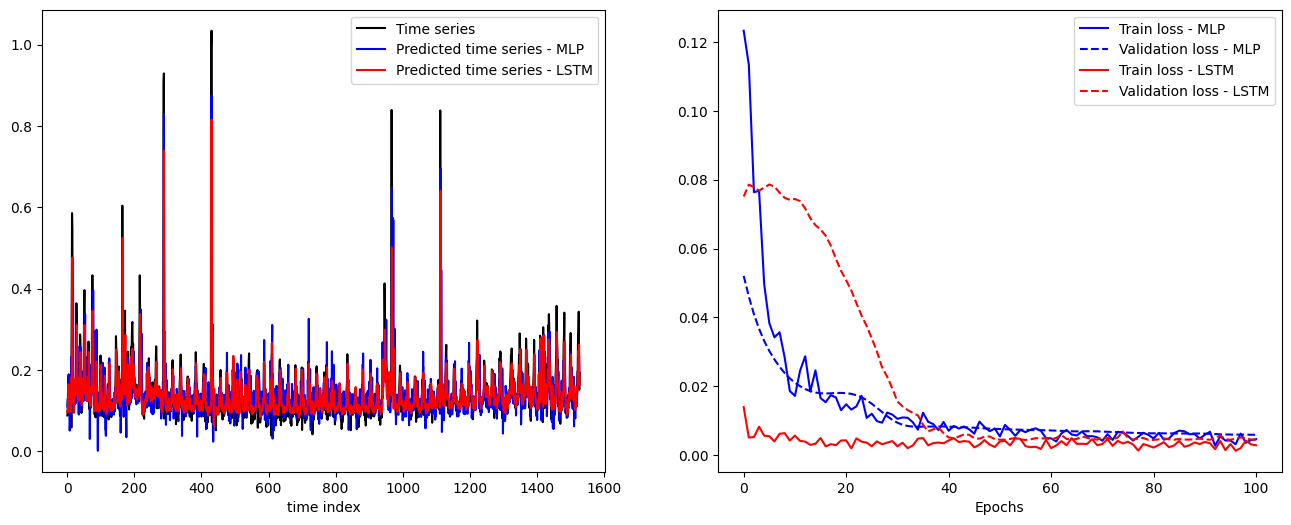

In [15]:
fig1, axs = plt.subplots(1, 2, figsize=(16, 6))
# Plot true time series once
axs[0].plot(Ydata, color='k', label='Time series')

plot_results_training(axs, y_pred_net, loss_train_net, loss_val_net, "MLP", color='b')
plot_results_training(axs, y_pred_lstm, loss_train_lstm, loss_val_lstm, "LSTM", color='r')

In [16]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df, y_pred_lstm, pred_error_lstm, anomaly_times, anomaly_windows, n_burn_in)
fig.show()

In [17]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df, y_pred_net, pred_error_net, anomaly_times, anomaly_windows, n_burn_in)
fig.show()